<a href="https://colab.research.google.com/github/Digital1st/Assessment/blob/main/Another_copy_of_Tft_working2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import torch, numpy as np
from torch import nn

# 1. Create mock data: 100 time series samples, each with 12 timesteps
batch_size, seq_len, pred_len, num_features = 32, 12, 3, 4
x_past = torch.randn(batch_size, seq_len, num_features)           # encoder input
x_future = torch.randn(batch_size, pred_len, num_features)        # decoder input
y_future = torch.randn(batch_size, pred_len, 1)                   # target to predict
static_feat = torch.randn(batch_size, 8)                          # static features per sample

# 2. Minimal TFT model
class MiniTFT(nn.Module):
    def __init__(self):
        super().__init__()
        d_model = 16
        self.static_enc = nn.Linear(8, d_model)
        self.input_proj = nn.Linear(num_features, d_model)
        self.lstm = nn.LSTM(d_model, d_model, batch_first=True)
        self.attn = nn.MultiheadAttention(d_model, num_heads=2, batch_first=True)
        self.output = nn.Linear(d_model, 1)

    def forward(self, x_past, x_future, static):
        batch = x_past.size(0)
        s = self.static_enc(static).unsqueeze(1)  # (B, 1, d_model)
        x = torch.cat([x_past, x_future], dim=1)  # (B, T+F, F)
        x = self.input_proj(x) + s                # broadcast static context
        lstm_out, _ = self.lstm(x)                # (B, T+F, d_model)
        attn_out, _ = self.attn(lstm_out, lstm_out, lstm_out)
        return self.output(attn_out[:, -pred_len:])  # only forecast part

# 3. Train
model = MiniTFT(); loss_fn = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(1500):
    model.train(); opt.zero_grad()
    out = model(x_past, x_future, static_feat)
    loss = loss_fn(out, y_future)
    loss.backward(); opt.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: loss={loss.item():.4f}")

Epoch 0: loss=0.9076
Epoch 10: loss=0.8764
Epoch 20: loss=0.8456
Epoch 30: loss=0.7888
Epoch 40: loss=0.7108
Epoch 50: loss=0.6519
Epoch 60: loss=0.6056
Epoch 70: loss=0.5773
Epoch 80: loss=0.5571
Epoch 90: loss=0.5397
Epoch 100: loss=0.5263
Epoch 110: loss=0.5186
Epoch 120: loss=0.5148
Epoch 130: loss=0.5122
Epoch 140: loss=0.5097
Epoch 150: loss=0.5069
Epoch 160: loss=0.5036
Epoch 170: loss=0.4991
Epoch 180: loss=0.4921
Epoch 190: loss=0.4795
Epoch 200: loss=0.4564
Epoch 210: loss=0.4211
Epoch 220: loss=0.3713
Epoch 230: loss=0.3114
Epoch 240: loss=0.2493
Epoch 250: loss=0.2087
Epoch 260: loss=0.1770
Epoch 270: loss=0.1481
Epoch 280: loss=0.1263
Epoch 290: loss=0.1095
Epoch 300: loss=0.0943
Epoch 310: loss=0.0804
Epoch 320: loss=0.0687
Epoch 330: loss=0.0582
Epoch 340: loss=0.0481
Epoch 350: loss=0.0387
Epoch 360: loss=0.0302
Epoch 370: loss=0.0214
Epoch 380: loss=0.0149
Epoch 390: loss=0.0110
Epoch 400: loss=0.0086
Epoch 410: loss=0.0067
Epoch 420: loss=0.0055
Epoch 430: loss=0.0040

In [ ]:

import yfinance as yf
import torch, numpy as np
from torch import nn
from sklearn.preprocessing import StandardScaler

# 1. Download SOL-GBP data
df = yf.download("SOL-GBP", start="2021-01-01", end="2024-01-01", interval="1d")
df = df[['Open', 'High', 'Low', 'Close']]  # Use 4 features

# 2. Preprocess data
scaler = StandardScaler()
scaled = scaler.fit_transform(df.values)
seq_len, pred_len = 12, 3
X_past, X_future, Y_future = [], [], []

for i in range(len(scaled) - seq_len - pred_len):
    X_past.append(scaled[i:i+seq_len])
    X_future.append(scaled[i+seq_len:i+seq_len+pred_len])
    Y_future.append(scaled[i+seq_len:i+seq_len+pred_len, 3])  # Target: Close price

x_past = torch.tensor(X_past, dtype=torch.float32)
x_future = torch.tensor(X_future, dtype=torch.float32)
y_future = torch.tensor(Y_future, dtype=torch.float32).unsqueeze(-1)
static_feat = torch.zeros(len(x_past), 8)  # Dummy static features

# 3. Define MiniTFT
class MiniTFT(nn.Module):
    def __init__(self):
        super().__init__()
        d_model = 16
        self.static_enc = nn.Linear(8, d_model)
        self.input_proj = nn.Linear(4, d_model)
        self.lstm = nn.LSTM(d_model, d_model, batch_first=True)
        self.attn = nn.MultiheadAttention(d_model, num_heads=2, batch_first=True)
        self.output = nn.Linear(d_model, 1)

    def forward(self, x_past, x_future, static):
        s = self.static_enc(static).unsqueeze(1)
        x = torch.cat([x_past, x_future], dim=1)
        x = self.input_proj(x) + s
        lstm_out, _ = self.lstm(x)
        attn_out, _ = self.attn(lstm_out, lstm_out, lstm_out)
        return self.output(attn_out[:, -pred_len:])

# 4. Train
model = MiniTFT()
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(300):
    model.train(); opt.zero_grad()
    out = model(x_past, x_future, static_feat)
    loss = loss_fn(out, y_future)
    loss.backward(); opt.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: loss={loss.item():.4f}")

[*********************100%***********************]  1 of 1 completed


Epoch 0: loss=1.0009
Epoch 10: loss=0.8740
Epoch 20: loss=0.6911
Epoch 30: loss=0.4209
Epoch 40: loss=0.1409
Epoch 50: loss=0.1047
Epoch 60: loss=0.0749
Epoch 70: loss=0.0659
Epoch 80: loss=0.0556
Epoch 90: loss=0.0497
Epoch 100: loss=0.0443
Epoch 110: loss=0.0405
Epoch 120: loss=0.0377
Epoch 130: loss=0.0355
Epoch 140: loss=0.0339
Epoch 150: loss=0.0326
Epoch 160: loss=0.0316
Epoch 170: loss=0.0306
Epoch 180: loss=0.0298
Epoch 190: loss=0.0290
Epoch 200: loss=0.0282
Epoch 210: loss=0.0275
Epoch 220: loss=0.0267
Epoch 230: loss=0.0260
Epoch 240: loss=0.0254
Epoch 250: loss=0.0247
Epoch 260: loss=0.0239
Epoch 270: loss=0.0231
Epoch 280: loss=0.0223
Epoch 290: loss=0.0213


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
<ipython-input-1-83711ca957b4>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  x_past = torch.tensor(X_past, dtype=torch.float32)


Epoch 0: loss=1.0368
Epoch 10: loss=0.9732
Epoch 20: loss=0.8433
Epoch 30: loss=0.6129
Epoch 40: loss=0.3277
Epoch 50: loss=0.2452
Epoch 60: loss=0.2167
Epoch 70: loss=0.1965


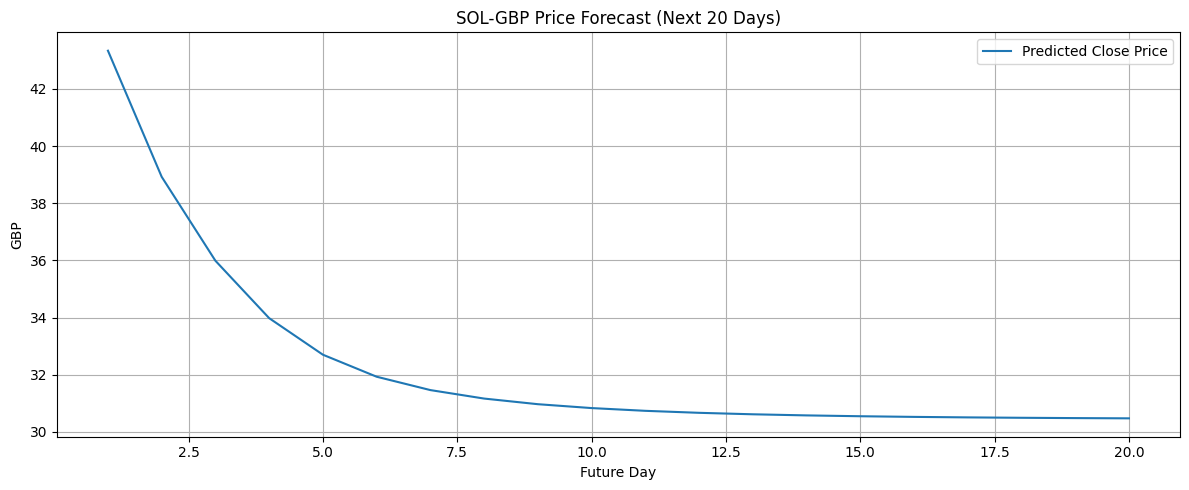

In [ ]:

import yfinance as yf
import torch, numpy as np
from torch import nn
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 1. Download SOL-GBP data
df = yf.download("SOL-GBP", start="2020-01-01", end="2024-01-01", interval="1d")
df = df[['Open', 'High', 'Low', 'Close']].dropna()

# 2. Preprocess
scaler = StandardScaler()
scaled = scaler.fit_transform(df.values)

seq_len, pred_len = 100, 20
num_features = 4

X_past, X_future, Y_future = [], [], []

for i in range(len(scaled) - seq_len - pred_len):
    X_past.append(scaled[i:i+seq_len])
    X_future.append(scaled[i+seq_len:i+seq_len+pred_len])
    Y_future.append(scaled[i+seq_len:i+seq_len+pred_len, 3])  # Close price

x_past = torch.tensor(X_past, dtype=torch.float32)
x_future = torch.tensor(X_future, dtype=torch.float32)
y_future = torch.tensor(Y_future, dtype=torch.float32).unsqueeze(-1)
static_feat = torch.zeros(len(x_past), 8)

# 3. Model
class MiniTFT(nn.Module):
    def __init__(self):
        super().__init__()
        d_model = 16
        self.static_enc = nn.Linear(8, d_model)
        self.input_proj = nn.Linear(num_features, d_model)
        self.lstm = nn.LSTM(d_model, d_model, batch_first=True)
        self.attn = nn.MultiheadAttention(d_model, num_heads=2, batch_first=True)
        self.output = nn.Linear(d_model, 1)

    def forward(self, x_past, x_future, static):
        s = self.static_enc(static).unsqueeze(1)
        x = torch.cat([x_past, x_future], dim=1)
        x = self.input_proj(x) + s
        lstm_out, _ = self.lstm(x)
        attn_out, _ = self.attn(lstm_out, lstm_out, lstm_out)
        return self.output(attn_out[:, -pred_len:])

# 4. Train
model = MiniTFT()
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(80):
    model.train(); opt.zero_grad()
    out = model(x_past, x_future, static_feat)
    loss = loss_fn(out, y_future)
    loss.backward(); opt.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: loss={loss.item():.4f}")

# 5. Predict future
last_100 = scaled[-seq_len:]
x_past_pred = torch.tensor(last_100, dtype=torch.float32).unsqueeze(0)
x_future_pred = torch.zeros((1, pred_len, 4))
static_pred = torch.zeros((1, 8))

model.eval()
with torch.no_grad():
    y_pred_scaled = model(x_past_pred, x_future_pred, static_pred)
    y_pred_scaled = y_pred_scaled.squeeze().numpy()

# 6. Inverse transform Close prices
dummy = np.zeros((pred_len, 4))
dummy[:, 3] = y_pred_scaled
y_pred_real = scaler.inverse_transform(dummy)[:, 3]

# 7. Plot
plt.figure(figsize=(12, 5))
plt.title("SOL-GBP Price Forecast (Next 20 Days)")
plt.plot(range(1, 21), y_pred_real, label="Predicted Close Price")
plt.xlabel("Future Day")
plt.ylabel("GBP")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:

import yfinance as yf
import torch, numpy as np
from torch import nn
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

# 1. Load & prepare data
df = yf.download("SOL-GBP", start="2020-01-01", interval="1d")[['Open', 'High', 'Low', 'Close']].dropna()
scaler = StandardScaler()
scaled = scaler.fit_transform(df.values)
seq_len, pred_len, num_features = 100, 20, 4

X_past, X_future, Y_future, static = [], [], [], []
for i in range(len(scaled) - seq_len - pred_len):
    past = scaled[i:i+seq_len]
    future = scaled[i+seq_len:i+seq_len+pred_len]
    target = scaled[i+seq_len:i+seq_len+pred_len, 3]
    dow = pd.get_dummies(df.index[i+seq_len].dayofweek).reindex(columns=range(7), fill_value=0).values
    X_past.append(past)
    X_future.append(future)
    Y_future.append(target)
    static.append(np.tile(dow, (1))[None, :])

x_past = torch.tensor(X_past, dtype=torch.float32)
x_future = torch.tensor(X_future, dtype=torch.float32)
y_future = torch.tensor(Y_future, dtype=torch.float32).unsqueeze(-1)
static_feat = torch.tensor(np.vstack(static), dtype=torch.float32)

# 2. Train/val split
train_size = int(0.8 * len(x_past))
train_data = (x_past[:train_size], x_future[:train_size], y_future[:train_size], static_feat[:train_size])
val_data = (x_past[train_size:], x_future[train_size:], y_future[train_size:], static_feat[train_size:])

# 3. Model
class MiniTFT(nn.Module):
    def __init__(self):
        super().__init__()
        d_model = 32
        self.static_enc = nn.Linear(7, d_model)
        self.input_proj = nn.Linear(num_features, d_model)
        self.lstm = nn.LSTM(d_model, d_model, batch_first=True)
        self.attn = nn.MultiheadAttention(d_model, 2, batch_first=True)
        self.output = nn.Linear(d_model, 1)

    def forward(self, x_past, x_future, static):
        s = self.static_enc(static).unsqueeze(1)
        x = torch.cat([x_past, x_future], dim=1)
        x = self.input_proj(x) + s
        lstm_out, _ = self.lstm(x)
        attn_out, _ = self.attn(lstm_out, lstm_out, lstm_out)
        return self.output(attn_out[:, -pred_len:])

model = MiniTFT(); opt = torch.optim.Adam(model.parameters(), lr=1e-3); loss_fn = nn.MSELoss()

# 4. Training
for epoch in range(60):
    model.train(); opt.zero_grad()
    out = model(*train_data[:3], train_data[3])
    loss = loss_fn(out, train_data[2])
    loss.backward(); opt.step()
    if epoch % 20 == 0:
        model.eval()
        with torch.no_grad():
            val_pred = model(*val_data[:3], val_data[3])
            val_loss = loss_fn(val_pred, val_data[2])
        print(f"Epoch {epoch}: train={loss.item():.4f}, val={val_loss.item():.4f}")

# 5. Predict next 20 days
x_past_pred = torch.tensor(scaled[-seq_len:], dtype=torch.float32).unsqueeze(0)
x_future_pred = x_past_pred[:, -pred_len:, :]  # repeat last 20 steps
dow = pd.get_dummies(df.index[-1].dayofweek).reindex(columns=range(7), fill_value=0).values
static_pred = torch.tensor(dow[None, :], dtype=torch.float32)

model.eval()
with torch.no_grad():
    y_scaled_pred = model(x_past_pred, x_future_pred, static_pred).squeeze().numpy()

# 6. Inverse transform Close prices
dummy = np.zeros((pred_len, 4)); dummy[:, 3] = y_scaled_pred
y_real_pred = scaler.inverse_transform(dummy)[:, 3]

# 7. Plot prediction
plt.figure(figsize=(12, 5))
plt.plot(range(1, 21), y_real_pred, label="Predicted SOL-GBP Close")
if len(val_data[2]) > 0:
    actual_close = scaler.inverse_transform(np.hstack([np.zeros((pred_len, 3)), val_data[2][-1].numpy()]))[:, 3]
    plt.plot(range(1, 21), actual_close, label="Actual (Last Sample)", linestyle='--')
plt.title("SOL-GBP Forecast (Next 20 Days)")
plt.xlabel("Future Day"); plt.ylabel("Price (GBP)")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

[*********************100%***********************]  1 of 1 completed


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.

In [ ]:

import yfinance as yf
import torch, numpy as np
from torch import nn
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

# 1. Load & prepare data
df = yf.download("SOL-GBP", start="2020-01-01", interval="1d")[['Open', 'High', 'Low', 'Close']].dropna()
scaler = StandardScaler()
scaled = scaler.fit_transform(df.values)
seq_len, pred_len, num_features = 100, 20, 4

X_past, X_future, Y_future, static = [], [], [], []
for i in range(len(scaled) - seq_len - pred_len):
    past = scaled[i:i+seq_len]
    future = scaled[i+seq_len:i+seq_len+pred_len]
    target = scaled[i+seq_len:i+seq_len+pred_len, 3]
    # One-hot encode day-of-week as static feature
    dow = pd.get_dummies([df.index[i+seq_len].dayofweek]).reindex(columns=range(7), fill_value=0).values[0]
    X_past.append(past)
    X_future.append(future)
    Y_future.append(target)
    static.append(dow)

x_past = torch.tensor(np.array(X_past), dtype=torch.float32)
x_future = torch.tensor(np.array(X_future), dtype=torch.float32)
y_future = torch.tensor(np.array(Y_future), dtype=torch.float32).unsqueeze(-1)
static_feat = torch.tensor(np.vstack(static), dtype=torch.float32)

# 2. Train/val split
train_size = int(0.8 * len(x_past))
train_data = (x_past[:train_size], x_future[:train_size], y_future[:train_size], static_feat[:train_size])
val_data = (x_past[train_size:], x_future[train_size:], y_future[train_size:], static_feat[train_size:])

# 3. Model
class MiniTFT(nn.Module):
    def __init__(self):
        super().__init__()
        d_model = 32
        self.static_enc = nn.Linear(7, d_model)
        self.input_proj = nn.Linear(num_features, d_model)
        self.lstm = nn.LSTM(d_model, d_model, batch_first=True)
        self.attn = nn.MultiheadAttention(d_model, 2, batch_first=True)
        self.output = nn.Linear(d_model, 1)

    def forward(self, x_past, x_future, static):
        s = self.static_enc(static).unsqueeze(1)
        x = torch.cat([x_past, x_future], dim=1)
        x = self.input_proj(x) + s
        lstm_out, _ = self.lstm(x)
        attn_out, _ = self.attn(lstm_out, lstm_out, lstm_out)
        return self.output(attn_out[:, -pred_len:])

model = MiniTFT()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# 4. Training
for epoch in range(200):
    model.train(); opt.zero_grad()
    out = model(*train_data[:3], train_data[3])
    loss = loss_fn(out, train_data[2])
    loss.backward(); opt.step()
    if epoch % 20 == 0:
        model.eval()
        with torch.no_grad():
            val_pred = model(*val_data[:3], val_data[3])
            val_loss = loss_fn(val_pred, val_data[2])
        print(f"Epoch {epoch}: train={loss.item():.4f}, val={val_loss.item():.4f}")

# 5. Predict next 20 days
x_past_pred = torch.tensor(scaled[-seq_len:], dtype=torch.float32).unsqueeze(0)
x_future_pred = x_past_pred[:, -pred_len:, :]  # repeat last 20 steps
dow_pred = pd.get_dummies([df.index[-1].dayofweek]).reindex(columns=range(7), fill_value=0).values[0]
static_pred = torch.tensor(dow_pred[None, :], dtype=torch.float32)

model.eval()
with torch.no_grad():
    y_scaled_pred = model(x_past_pred, x_future_pred, static_pred).squeeze().numpy()

# 6. Inverse transform Close prices
dummy = np.zeros((pred_len, 4)); dummy[:, 3] = y_scaled_pred
y_real_pred = scaler.inverse_transform(dummy)[:, 3]

# 7. Plot prediction
plt.figure(figsize=(12, 5))
plt.plot(range(1, 21), y_real_pred, label="Predicted SOL-GBP Close")
if len(val_data[2]) > 0:
    actual_close = scaler.inverse_transform(np.hstack([np.zeros((pred_len, 3)), val_data[2][-1].numpy()]))[:, 3]
    plt.plot(range(1, 21), actual_close, label="Actual (Last Sample)", linestyle='--')
plt.title("SOL-GBP Forecast (Next 20 Days)")
plt.xlabel("Future Day"); plt.ylabel("Price (GBP)")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

[*********************100%***********************]  1 of 1 completed


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.

In [ ]:
import yfinance as yf
import torch, numpy as np
from torch import nn
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

# 1. Load & prepare data
df = yf.download("SOL-GBP", start="2020-01-01", interval="1d")[['Open', 'High', 'Low', 'Close']].dropna()
scaler = StandardScaler()
scaled = scaler.fit_transform(df.values)
seq_len, pred_len, num_features = 100, 20, 4

X_past, X_future, Y_future, static = [], [], [], []
for i in range(len(scaled) - seq_len - pred_len):
    past = scaled[i:i+seq_len]
    future = scaled[i+seq_len:i+seq_len+pred_len]
    target = scaled[i+seq_len:i+seq_len+pred_len, 3]
    # One-hot encode day-of-week as static feature
    dow = pd.get_dummies([df.index[i+seq_len].dayofweek]).reindex(columns=range(7), fill_value=0).values[0]
    X_past.append(past)
    X_future.append(future)
    Y_future.append(target)
    static.append(dow)

x_past = torch.tensor(np.array(X_past), dtype=torch.float32)
x_future = torch.tensor(np.array(X_future), dtype=torch.float32)
y_future = torch.tensor(np.array(Y_future), dtype=torch.float32).unsqueeze(-1)
static_feat = torch.tensor(np.vstack(static), dtype=torch.float32)

# 2. Train/val split
train_size = int(0.8 * len(x_past))
train_data = (x_past[:train_size], x_future[:train_size], y_future[:train_size], static_feat[:train_size])
val_data = (x_past[train_size:], x_future[train_size:], y_future[train_size:], static_feat[train_size:])

# 3. Model
class MiniTFT(nn.Module):
    def __init__(self):
        super().__init__()
        d_model = 32
        self.static_enc = nn.Linear(7, d_model)
        self.input_proj = nn.Linear(num_features, d_model)
        self.lstm = nn.LSTM(d_model, d_model, batch_first=True)
        self.attn = nn.MultiheadAttention(d_model, 2, batch_first=True)
        self.output = nn.Linear(d_model, 1)

    def forward(self, x_past, x_future, static):
        s = self.static_enc(static).unsqueeze(1)
        x = torch.cat([x_past, x_future], dim=1)
        x = self.input_proj(x) + s
        lstm_out, _ = self.lstm(x)
        attn_out, _ = self.attn(lstm_out, lstm_out, lstm_out)
        return self.output(attn_out[:, -pred_len:])

model = MiniTFT()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# 4. Training
for epoch in range(60):
    model.train(); opt.zero_grad()
    out = model(*train_data[:3], train_data[3])
    loss = loss_fn(out, train_data[2])
    loss.backward(); opt.step()
    if epoch % 20 == 0:
        model.eval()
        with torch.no_grad():
            val_pred = model(*val_data[:3], val_data[3])
            val_loss = loss_fn(val_pred, val_data[2])
        print(f"Epoch {epoch}: train={loss.item():.4f}, val={val_loss.item():.4f}")

# 5. Predict next 20 days
x_past_pred = torch.tensor(scaled[-seq_len:], dtype=torch.float32).unsqueeze(0)
x_future_pred = x_past_pred[:, -pred_len:, :]  # repeat last 20 steps
dow_pred = pd.get_dummies([df.index[-1].dayofweek]).reindex(columns=range(7), fill_value=0).values[0]
static_pred = torch.tensor(dow_pred[None, :], dtype=torch.float32)

model.eval()
with torch.no_grad():
    y_scaled_pred = model(x_past_pred, x_future_pred, static_pred).squeeze().numpy()

# 6. Inverse transform Close prices
dummy = np.zeros((pred_len, 4)); dummy[:, 3] = y_scaled_pred
y_real_pred = scaler.inverse_transform(dummy)[:, 3]

# 7. Plot prediction
plt.figure(figsize=(12, 5))
plt.plot(range(1, 21), y_real_pred, label="Predicted SOL-GBP Close")
if len(val_data[2]) > 0:
    actual_close = scaler.inverse_transform(np.hstack([np.zeros((pred_len, 3)), val_data[2][-1].numpy()]))[:, 3]
    plt.plot(range(1, 21), actual_close, label="Actual (Last Sample)", linestyle='--')
plt.title("SOL-GBP Forecast (Next 20 Days)")
plt.xlabel("Future Day"); plt.ylabel("Price (GBP)")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

[*********************100%***********************]  1 of 1 completed


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.

In [ ]:
import yfinance as yf
import torch, numpy as np
from torch import nn
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

# 1. Load & prepare data
df = yf.download("SOL-GBP", start="2020-01-01", interval="1d")[['Open', 'High', 'Low', 'Close']].dropna()
scaler = StandardScaler()
scaled = scaler.fit_transform(df.values)
seq_len, pred_len, num_features = 100, 20, 4

X_past, X_future, Y_future, static = [], [], [], []
for i in range(len(scaled) - seq_len - pred_len):
    past = scaled[i:i+seq_len]
    future = scaled[i+seq_len:i+seq_len+pred_len]
    target = scaled[i+seq_len:i+seq_len+pred_len, 3]

    # Fixed: Create one-hot day-of-week as float32 numpy array (length=7)
    dow = np.zeros(7, dtype=np.float32)
    dow[df.index[i+seq_len].dayofweek] = 1.0

    X_past.append(past)
    X_future.append(future)
    Y_future.append(target)
    static.append(dow)

x_past = torch.tensor(np.array(X_past), dtype=torch.float32)
x_future = torch.tensor(np.array(X_future), dtype=torch.float32)
y_future = torch.tensor(np.array(Y_future), dtype=torch.float32).unsqueeze(-1)
static_feat = torch.tensor(np.vstack(static), dtype=torch.float32)

# 2. Train/val split
train_size = int(0.8 * len(x_past))
train_data = (x_past[:train_size], x_future[:train_size], y_future[:train_size], static_feat[:train_size])
val_data = (x_past[train_size:], x_future[train_size:], y_future[train_size:], static_feat[train_size:])

# 3. Model
class MiniTFT(nn.Module):
    def __init__(self):
        super().__init__()
        d_model = 32
        self.static_enc = nn.Linear(7, d_model)
        self.input_proj = nn.Linear(num_features, d_model)
        self.lstm = nn.LSTM(d_model, d_model, batch_first=True)
        self.attn = nn.MultiheadAttention(d_model, 2, batch_first=True)
        self.output = nn.Linear(d_model, 1)

    def forward(self, x_past, x_future, static):
        s = self.static_enc(static).unsqueeze(1)
        x = torch.cat([x_past, x_future], dim=1)
        x = self.input_proj(x) + s
        lstm_out, _ = self.lstm(x)
        attn_out, _ = self.attn(lstm_out, lstm_out, lstm_out)
        return self.output(attn_out[:, -pred_len:])

model = MiniTFT()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# 4. Training
for epoch in range(200):
    model.train(); opt.zero_grad()
    out = model(*train_data[:3], train_data[3])
    loss = loss_fn(out, train_data[2])
    loss.backward(); opt.step()
    if epoch % 20 == 0:
        model.eval()
        with torch.no_grad():
            val_pred = model(*val_data[:3], val_data[3])
            val_loss = loss_fn(val_pred, val_data[2])
        print(f"Epoch {epoch}: train={loss.item():.4f}, val={val_loss.item():.4f}")

# 5. Predict next 20 days
x_past_pred = torch.tensor(scaled[-seq_len:], dtype=torch.float32).unsqueeze(0)
# Use repeated last step as future input
last_step = x_past_pred[:, -1:, :].repeat(1, pred_len, 1)
x_future_pred = last_step

dow_pred = np.zeros(7, dtype=np.float32)
dow_pred[df.index[-1].dayofweek] = 1.0
static_pred = torch.tensor(dow_pred[None, :], dtype=torch.float32)

model.eval()
with torch.no_grad():
    y_scaled_pred = model(x_past_pred, x_future_pred, static_pred).squeeze().numpy()

# 6. Inverse transform Close prices
dummy = np.zeros((pred_len, 4))
dummy[:, 3] = y_scaled_pred
y_real_pred = scaler.inverse_transform(dummy)[:, 3]

# 7. Plot prediction
plt.figure(figsize=(12, 5))
plt.plot(range(1, 21), y_real_pred, label="Predicted SOL-GBP Close")

if len(val_data[2]) > 0:
    actual_close = scaler.inverse_transform(np.hstack([
        np.zeros((pred_len, 3)), val_data[2][-1].numpy()
    ]))[:, 3]
    plt.plot(range(1, 21), actual_close, label="Actual (Last Sample)", linestyle='--')

plt.title("SOL-GBP Forecast (Next 20 Days)")
plt.xlabel("Future Day")
plt.ylabel("Price (GBP)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

[*********************100%***********************]  1 of 1 completed


TypeError: MiniTFT.forward() takes 4 positional arguments but 5 were given

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Epoch 0: train=0.7266, val=2.2828
Epoch 20: train=0.2060, val=0.3726
Epoch 40: train=0.1277, val=0.3222
Epoch 60: train=0.0933, val=0.2974


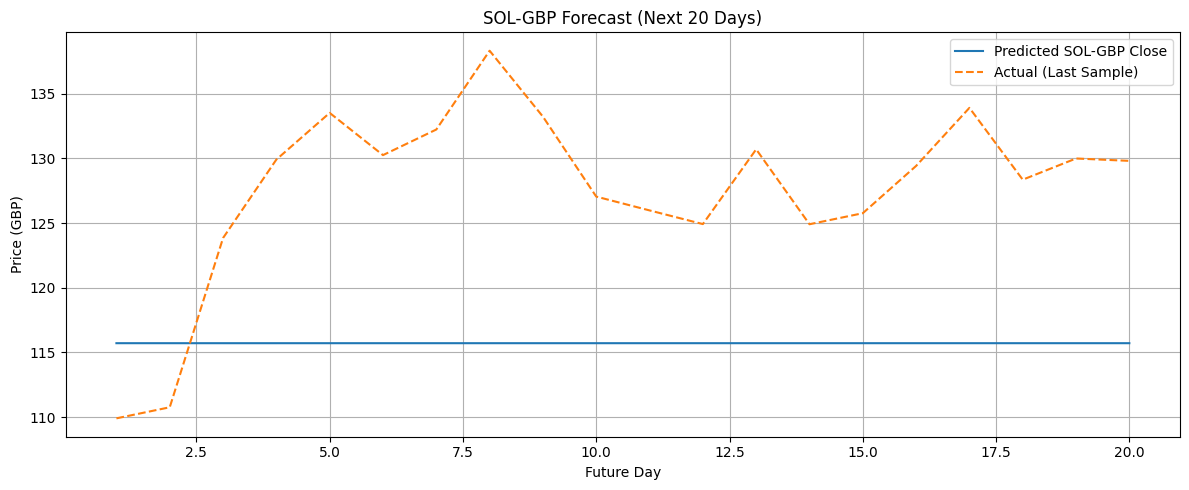

In [1]:
import yfinance as yf
import torch, numpy as np
from torch import nn
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

# 1. Load & prepare data
df = yf.download("SOL-GBP", start="2020-01-01", interval="1d")[['Open', 'High', 'Low', 'Close']].dropna()
scaler = StandardScaler()
scaled = scaler.fit_transform(df.values)
seq_len, pred_len, num_features = 100, 20, 4

X_past, X_future, Y_future, static = [], [], [], []
for i in range(len(scaled) - seq_len - pred_len):
    past = scaled[i:i+seq_len]
    future = scaled[i+seq_len:i+seq_len+pred_len]
    target = scaled[i+seq_len:i+seq_len+pred_len, 3]

    dow = np.zeros(7, dtype=np.float32)
    dow[df.index[i+seq_len].dayofweek] = 1.0

    X_past.append(past)
    X_future.append(future)
    Y_future.append(target)
    static.append(dow)

x_past = torch.tensor(np.array(X_past), dtype=torch.float32)
x_future = torch.tensor(np.array(X_future), dtype=torch.float32)
y_future = torch.tensor(np.array(Y_future), dtype=torch.float32).unsqueeze(-1)
static_feat = torch.tensor(np.vstack(static), dtype=torch.float32)

# 2. Train/val split
train_size = int(0.8 * len(x_past))
train_data = (x_past[:train_size], x_future[:train_size], y_future[:train_size], static_feat[:train_size])
val_data = (x_past[train_size:], x_future[train_size:], y_future[train_size:], static_feat[train_size:])

# 3. Model
class MiniTFT(nn.Module):
    def __init__(self):
        super().__init__()
        d_model = 32
        self.static_enc = nn.Linear(7, d_model)
        self.input_proj = nn.Linear(num_features, d_model)
        self.lstm = nn.LSTM(d_model, d_model, batch_first=True)
        self.attn = nn.MultiheadAttention(d_model, 2, batch_first=True)
        self.output = nn.Linear(d_model, 1)

    def forward(self, x_past, x_future, static):
        s = self.static_enc(static).unsqueeze(1)
        x = torch.cat([x_past, x_future], dim=1)
        x = self.input_proj(x) + s
        lstm_out, _ = self.lstm(x)
        attn_out, _ = self.attn(lstm_out, lstm_out, lstm_out)
        return self.output(attn_out[:, -pred_len:])

model = MiniTFT()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# 4. Training
for epoch in range(80):
    model.train()
    opt.zero_grad()
    out = model(train_data[0], train_data[1], train_data[3])   # Fixed call here
    loss = loss_fn(out, train_data[2])
    loss.backward()
    opt.step()

    if epoch % 20 == 0:
        model.eval()
        with torch.no_grad():
            val_pred = model(val_data[0], val_data[1], val_data[3])  # Fixed call here
            val_loss = loss_fn(val_pred, val_data[2])
        print(f"Epoch {epoch}: train={loss.item():.4f}, val={val_loss.item():.4f}")

# 5. Predict next 20 days
x_past_pred = torch.tensor(scaled[-seq_len:], dtype=torch.float32).unsqueeze(0)
last_step = x_past_pred[:, -1:, :].repeat(1, pred_len, 1)
x_future_pred = last_step

dow_pred = np.zeros(7, dtype=np.float32)
dow_pred[df.index[-1].dayofweek] = 1.0
static_pred = torch.tensor(dow_pred[None, :], dtype=torch.float32)

model.eval()
with torch.no_grad():
    y_scaled_pred = model(x_past_pred, x_future_pred, static_pred).squeeze().numpy()

# 6. Inverse transform Close prices
dummy = np.zeros((pred_len, 4))
dummy[:, 3] = y_scaled_pred
y_real_pred = scaler.inverse_transform(dummy)[:, 3]

# 7. Plot prediction
plt.figure(figsize=(12, 5))
plt.plot(range(1, 21), y_real_pred, label="Predicted SOL-GBP Close")

if len(val_data[2]) > 0:
    actual_close = scaler.inverse_transform(np.hstack([
        np.zeros((pred_len, 3)), val_data[2][-1].numpy()
    ]))[:, 3]
    plt.plot(range(1, 21), actual_close, label="Actual (Last Sample)", linestyle='--')

plt.title("SOL-GBP Forecast (Next 20 Days)")
plt.xlabel("Future Day")
plt.ylabel("Price (GBP)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()